In [10]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
from ActiveLearning import Classifier, GAL, GNN, ActiveLearningPipeline, generate_plot, GALClassifier
from sklearn.linear_model import LogisticRegression
import numpy.linalg as nla
import pickle
import networkx as nx
from sklearn.metrics.pairwise import pairwise_distances


In [11]:
with open('dataset_q1.pkl', 'rb') as f:
	dataset = pickle.load(f)

In [12]:
iterations = 40
budget_per_iter = 50
train_limit = 2010
gal = GAL(
	dataset,
	None,
	iterations,
	budget_per_iter,
	train_limit,
	.9,
	None,
	LogisticRegression,
	GNN
)

In [13]:
from collections import defaultdict
accuracy_scores_dict = defaultdict(list)

In [14]:
accuracy_scores_dict['GAL'] = gal.run_pipeline()

Iteration 1/40
Accuracy: 0.56
--------------
Iteration 2/40
Accuracy: 0.596
--------------
Iteration 3/40
Accuracy: 0.607
--------------
Iteration 4/40
Accuracy: 0.657
--------------
Iteration 5/40
Accuracy: 0.678
--------------
Iteration 6/40
Accuracy: 0.66
--------------
Iteration 7/40
Accuracy: 0.684
--------------
Iteration 8/40
Accuracy: 0.697
--------------
Iteration 9/40
Accuracy: 0.697
--------------
Iteration 10/40
Accuracy: 0.697
---------------
Iteration 11/40
Accuracy: 0.696
---------------
Iteration 12/40
Accuracy: 0.697
---------------
Iteration 13/40
Accuracy: 0.696
---------------
Iteration 14/40
Accuracy: 0.697
---------------
Iteration 15/40
Accuracy: 0.693
---------------
Iteration 16/40
Accuracy: 0.695
---------------
Iteration 17/40
Accuracy: 0.697
---------------
Iteration 18/40
Accuracy: 0.699
---------------
Iteration 19/40
Accuracy: 0.7
---------------
Iteration 20/40
Accuracy: 0.7
---------------
Iteration 21/40
Accuracy: 0.698
---------------
Iteration 22/40


In [15]:
selection_criteria = ['random', 'custom']
for criterion in selection_criteria:
	AL_class = ActiveLearningPipeline(dataset=dataset,
									selection_criterion=criterion,
									iterations=iterations,
									budget_per_iter=budget_per_iter,
									train_limit=train_limit)
	accuracy_scores_dict[criterion] = AL_class.run_pipeline()


Iteration 1/40
Accuracy: 0.56
----------------------------------------
Iteration 2/40
Accuracy: 0.691
----------------------------------------
Iteration 3/40
Accuracy: 0.69
----------------------------------------
Iteration 4/40
Accuracy: 0.688
----------------------------------------
Iteration 5/40
Accuracy: 0.69
----------------------------------------
Iteration 6/40
Accuracy: 0.695
----------------------------------------
Iteration 7/40
Accuracy: 0.696
----------------------------------------
Iteration 8/40
Accuracy: 0.695
----------------------------------------
Iteration 9/40
Accuracy: 0.698
----------------------------------------
Iteration 10/40
Accuracy: 0.699
----------------------------------------
Iteration 11/40
Accuracy: 0.7
----------------------------------------
Iteration 12/40
Accuracy: 0.699
----------------------------------------
Iteration 13/40
Accuracy: 0.699
----------------------------------------
Iteration 14/40
Accuracy: 0.701
---------------------------------

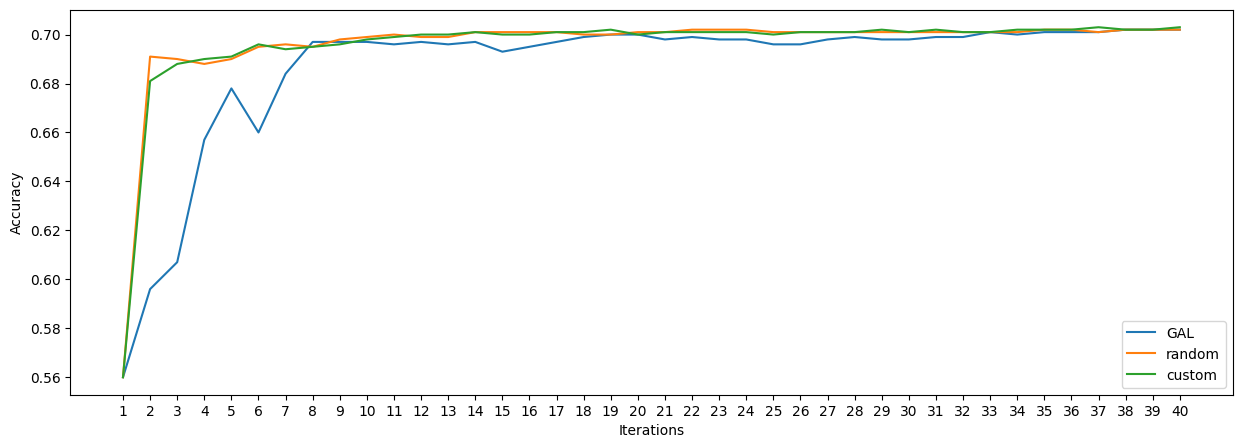

In [16]:
generate_plot(accuracy_scores_dict)

In [17]:
acc5plus = accuracy_scores_dict.copy()
for k, v in acc5plus.items():
	acc5plus[k] = v[6:]

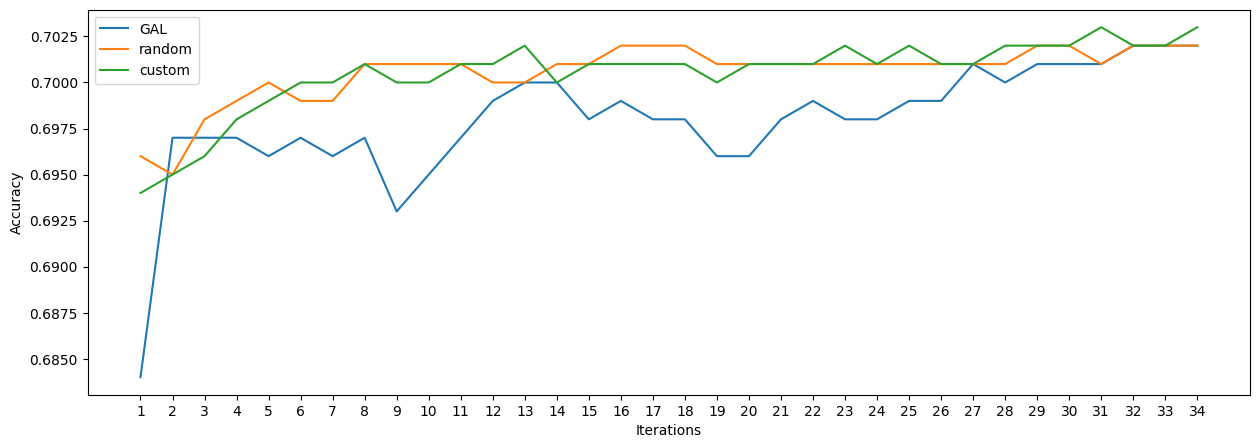

In [18]:
generate_plot(acc5plus)